In [1]:
import mpramnist
from mpramnist.Evfratov.dataset import EvfratovDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Evfratov

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import pytorch_lightning as L
import torch.nn.functional as F

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 103

## Some info

The dataset has a pair of attributes:

merge_last_classes — determines whether the last two classes should be merged into one.

length_of_seq — determines which dataset to use. "23" refers to the dataset with sequences of length 23, and "33" refers to the dataset with sequences of length 33. The default is "23".

## Define set of transforms

In [3]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])

test_transform = t.Compose([ # test transforms are slightly different.
    t.Seq2Tensor(), 
    t.ReverseComplement(0), # Reverse complementary transformation for all sequences with a probability of 0
])

## Merging last 2 classes

### 8 classes

The data initially has 8 labels. 

You can train the model on all 8 classes, but the number of instances in the last class is extremely small. 

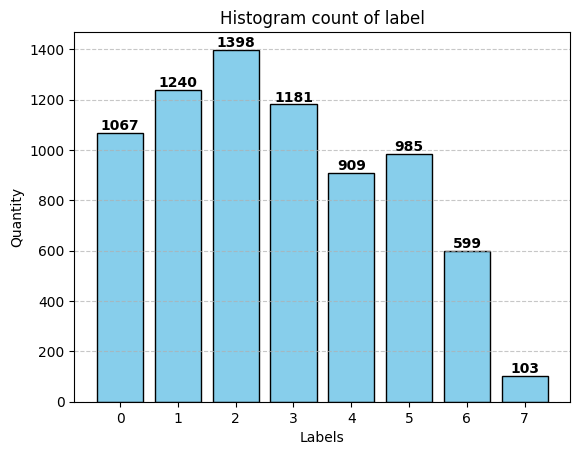

In [6]:
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform, root = "../data/") # use "train" for default training set
train_dataset.hist_plot()

Therefore, to balance class representation, we propose merging the last two classes into one.

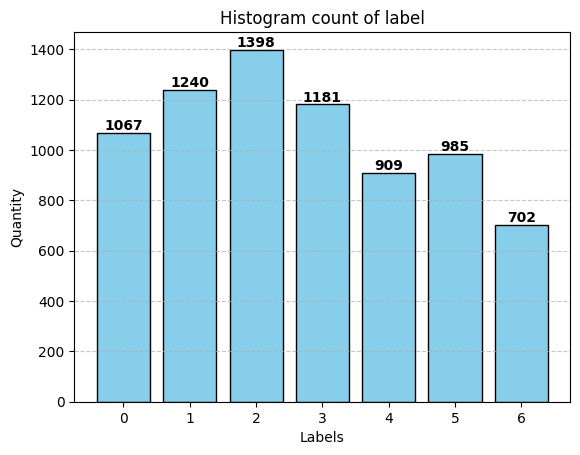

In [7]:
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform, root = "../data/") # use "train" for default training set
train_dataset.hist_plot()

## First, Lets work with sequences length of 23

The default value of *length_of_seq* is 23

In [4]:
length_of_seq = 23
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform, root = "../data/") # use "train" for default training set

val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                            transform=test_transform, root = "../data/") # use "val" for default validation set 

test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                             transform=test_transform, root = "../data/") # use "test" for default test set

In [5]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [6]:
N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

In [7]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = N_CLASSES,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Evfratov(model = model,
                           loss = nn.CrossEntropyLoss(),
                           n_classes = N_CLASSES,
                           weight_decay = 1e-1, lr = 1e-2, print_each = 1)

In [8]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=1` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.35221806168556213 | Val AUROC: 0.7904077768325806 | Val AUPR: 0.3571273684501648 |
| Val Precision: 0.33064013719558716 | Val Recall: 0.36951565742492676 | Val F1: 0.33342981338500977 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.37537407875061035 | Test AUROC: 0.787303626537323 | Test AUPR: 0.35529863834381104 |
| Test Precision: 0.4036330282688141 | Test Recall: 0.38330599665641785 | Test F1: 0.3541392683982849 
----------------------------------------------------------------------------------------------------



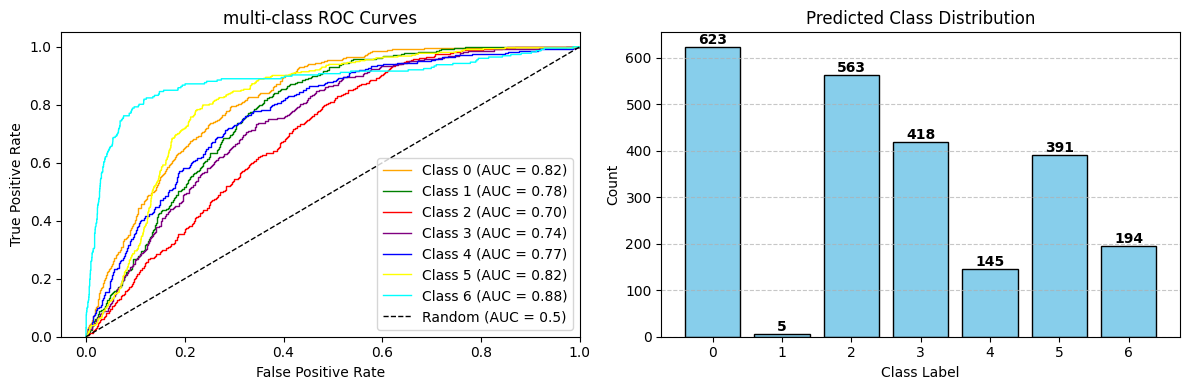

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5099307298660278
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5099307298660278}]

In [10]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)
trainer.test(seq_model, dataloaders = test_loader)

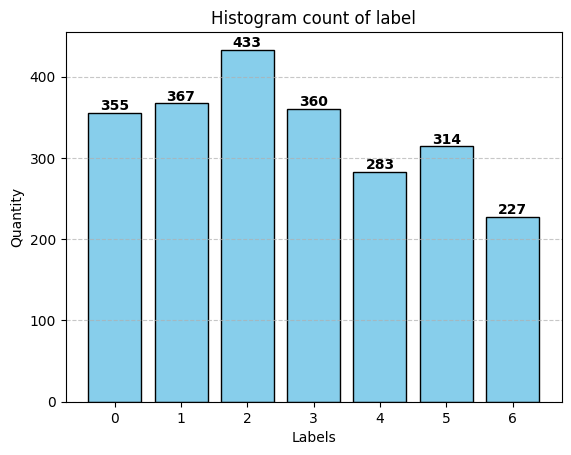

In [14]:
test_dataset.hist_plot()

## Second, Lets try with sequences length of 33

In [11]:
length_of_seq = 33
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes, 
                                length_of_seq = length_of_seq,
                              transform=train_transform, root = "../data/") 
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                              length_of_seq = length_of_seq,
                            transform=test_transform, root = "../data/") 
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                               length_of_seq = length_of_seq,
                             transform=test_transform, root = "../data/") 

In [12]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [13]:
N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

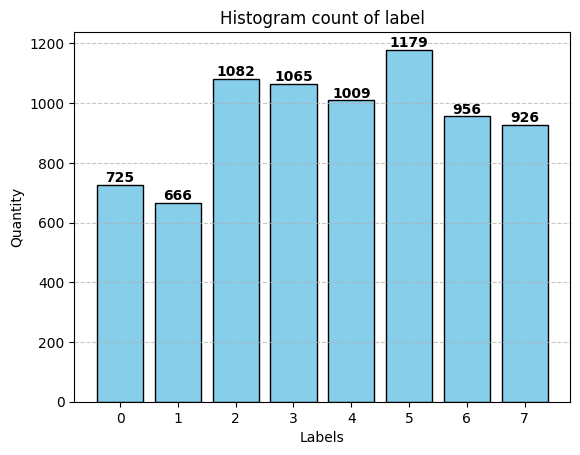

In [14]:
train_dataset.hist_plot()

In [15]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = N_CLASSES,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Evfratov(model = model,
                           loss = nn.CrossEntropyLoss(),
                           n_classes = N_CLASSES,
                           weight_decay = 1e-2, lr = 1e-2, print_each = 1)

In [16]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=1` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.2695743441581726 | Val AUROC: 0.7342572212219238 | Val AUPR: 0.271084189414978 |
| Val Precision: 0.268647700548172 | Val Recall: 0.2673744559288025 | Val F1: 0.22474801540374756 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.27628257870674133 | Test AUROC: 0.7253192067146301 | Test AUPR: 0.25231605768203735 |
| Test Precision: 0.20743750035762787 | Test Recall: 0.2676547169685364 | Test F1: 0.2264830768108368 
----------------------------------------------------------------------------------------------------



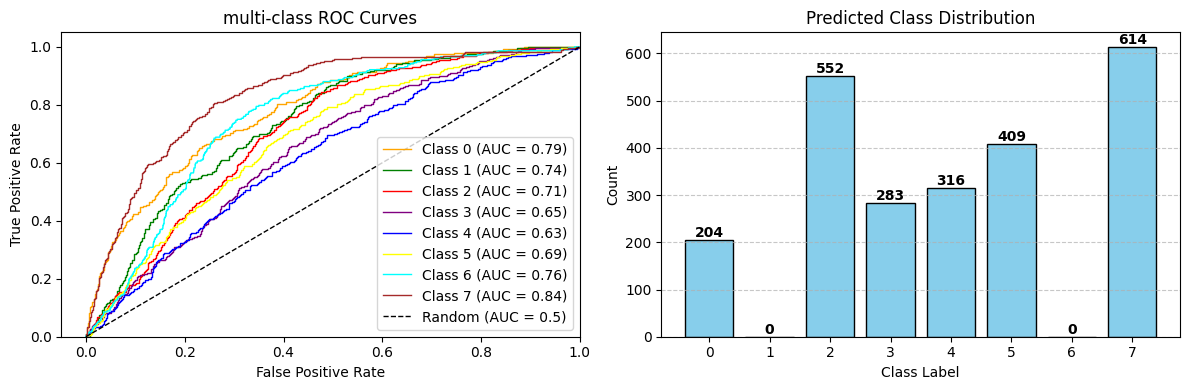

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.8052412271499634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.8052412271499634}]

In [17]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)
trainer.test(seq_model, dataloaders = test_loader)

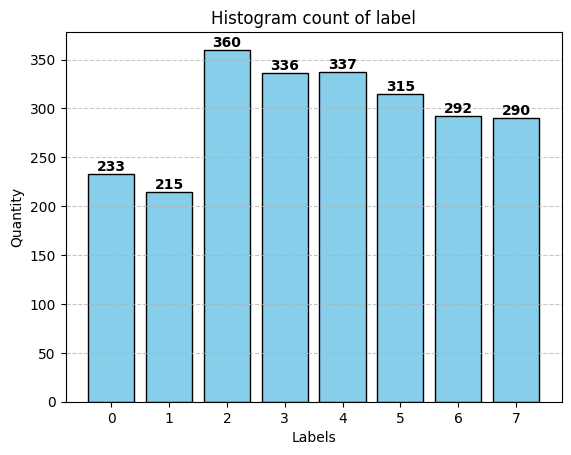

In [18]:
test_dataset.hist_plot()